
"""
Submission Rekomendasi Film - Diperbaiki
Proyek Sistem Rekomendasi Film dengan Content-Based dan Collaborative Filtering
"""

In [4]:
# 1. Uninstall numpy versi baru
!pip uninstall -y numpy

# 2. Install numpy versi kompatibel
!pip install numpy==1.26.4

# 3. Install scikit-surprise
!pip install scikit-surprise

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# **Import Library**

Tahap pertama adalah mengimpor semua library yang kita perlukan. Ini termasuk pandas untuk manipulasi data, numpy untuk operasi numerik, scikit-learn untuk Content-Based Filtering, dan surprise untuk Collaborative Filtering

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

print("Libraries imported successfully!")



Libraries imported successfully!


# **1. DATA LOADING**



Dataset MovieLens dimuat ke dalam DataFrame pandas. Dataset ini terdiri dari beberapa file CSV:                         
- `ratings.csv`: Berisi informasi rating film oleh pengguna.,
- `movies.csv`: Berisi informasi detail film seperti judul dan genre,
- `tags.csv`: Berisi tag yang diberikan pengguna untuk film."

In [2]:

print("\n--- Data Loading ---")
ratings_path = 'ratings.csv'
movies_path = 'movies.csv'
tags_path = 'tags.csv'

try:
    ratings = pd.read_csv(ratings_path)
    movies = pd.read_csv(movies_path)
    tags = pd.read_csv(tags_path)
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print("Error: Pastikan file CSV ada di direktori yang sama atau ganti path-nya.")
    exit()


--- Data Loading ---
Datasets loaded successfully!



# **2. DATA UNDERSTANDING (EDA)**


Pada tahap ini, dilakukan *Exploratory Data Analysis* (EDA) untuk memperoleh pemahaman yang lebih mendalam mengenai struktur, isi, dan karakteristik dataset.

Langkah-langkah EDA yang dilakukan antara lain:

- Menampilkan beberapa baris pertama dari setiap DataFrame menggunakan `head()`.
- Menampilkan informasi ringkas tentang DataFrame, termasuk tipe data dan jumlah nilai non-null dengan `info()`.
- Menghitung statistik dasar seperti jumlah pengguna unik, jumlah film unik, dan jumlah total rating.
- Membuat visualisasi distribusi rating untuk memahami kecenderungan pengguna dalam memberikan rating.
- Membuat visualisasi jumlah film per genre untuk mengidentifikasi genre yang paling dominan dalam dataset.

###**Menampilkan 5 Baris Pertama dari Setiap DataFrame**

- **Movies Data Head**:
  Menampilkan lima baris pertama dari dataset `movies`.

- **Ratings Data Head**:
  Menampilkan lima baris pertama dari dataset `ratings`.

- **Tags Data Head**:
  Menampilkan lima baris pertama dari dataset `tags`.
"""


### **Menampilkan Informasi Struktur Dataset**

Menggunakan fungsi `.info()` untuk melihat tipe data dan jumlah nilai non-null pada:
- Dataset `movies`
- Dataset `ratings`
- Dataset `tags`



In [3]:
print("\n--- Starting Data Understanding (EDA) ---")

# Menampilkan 5 baris pertama
print("\nMovies Data Head:")
print(movies.head())
print("\nRatings Data Head:")
print(ratings.head())
print("\nTags Data Head:")
print(tags.head())

# Menampilkan Info Dataset
print("\nInfo Movies:")
movies.info()
print("\nInfo Ratings:")
ratings.info()
print("\nInfo Tags:")
tags.info()




--- Starting Data Understanding (EDA) ---

Movies Data Head:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings Data Head:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Tags Data Head:
   userId  movieId              tag   timestamp
0       2    60756            

### **Statistik Dasar Dataset**

Beberapa informasi statistik dasar yang dihitung:
- Jumlah pengguna unik (`userId`)
- Jumlah film unik yang dirating (`movieId` di `ratings`)
- Jumlah film unik secara keseluruhan (`movieId` di `movies`)
- Jumlah total rating

In [4]:

# Statistik Dasar
n_users = ratings['userId'].nunique()
n_movies_rated = ratings['movieId'].nunique()
n_movies_total = movies['movieId'].nunique()
n_ratings = len(ratings)

print(f"\nJumlah pengguna unik: {n_users}")
print(f"Jumlah film unik di ratings: {n_movies_rated}")
print(f"Jumlah film unik di movies: {n_movies_total}")
print(f"Jumlah rating: {n_ratings}")



Jumlah pengguna unik: 610
Jumlah film unik di ratings: 9724
Jumlah film unik di movies: 9742
Jumlah rating: 100836


### **Visualisasi Distribusi Rating**

Visualisasi ini menunjukkan distribusi rating yang diberikan pengguna terhadap film, menggunakan `countplot` dari seaborn.

- X-axis: Nilai rating
- Y-axis: Jumlah rating yang diberikan
- Warna: Skema `viridis`

<ipython-input-5-63e8d7474059>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df_eda, palette='viridis')


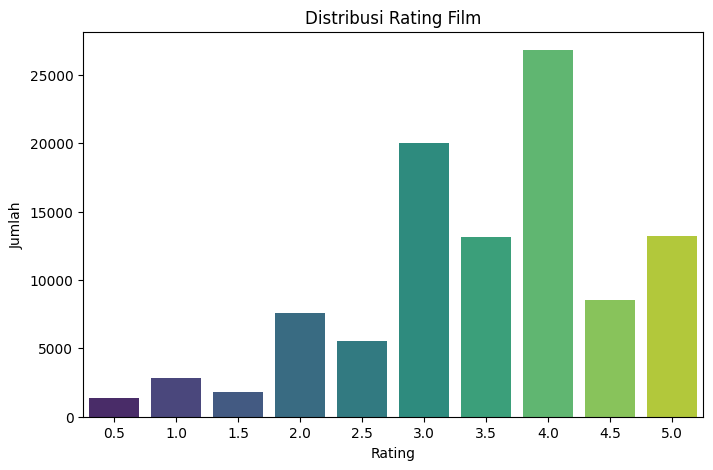

In [5]:

# Menggabungkan data HANYA untuk tujuan EDA (visualisasi)
df_eda = pd.merge(ratings, movies, on='movieId', how='left')

# Distribusi Rating
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df_eda, palette='viridis')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()


### **Visualisasi Jumlah Film per Genre**

Langkah-langkah:
- Genre film dari kolom `genres` dipecah berdasarkan tanda `|`.
- Kemudian dihitung frekuensi kemunculan setiap genre.
- Data divisualisasikan menggunakan `barplot`.

- X-axis: Jumlah film
- Y-axis: Nama genre
- Ukuran plot: 10x6 inci

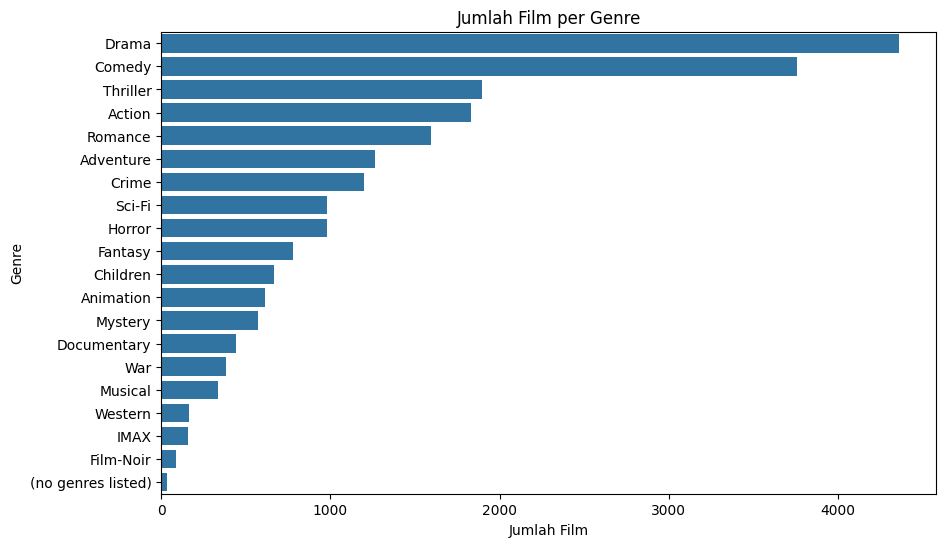

--- EDA Complete ---


In [6]:

# Pisahkan genre per film dan ubah jadi daftar
all_genres = movies['genres'].str.split('|').explode()
genre_counts = all_genres.value_counts()

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title('Jumlah Film per Genre')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.show()

print("--- EDA Complete ---")

"""EDA memberikan gambaran umum yang penting sebelum masuk ke tahap preprocessing dan pemodelan. Tahap ini selesai dengan informasi lengkap mengenai struktur, distribusi, dan karakteristik data








# **3. DATA PREPARATION**


Tahap ini bertujuan untuk menyiapkan data mentah agar sesuai dan optimal digunakan dalam pemodelan *machine learning*, baik untuk *content-based* maupun *collaborative filtering*.

## **3.1. Memproses Tags**

1. **Memproses Tags**
   - Semua teks tag diubah menjadi huruf kecil untuk konsistensi.
   - Baris yang memiliki tag kosong dihapus.
   - Semua tag yang diberikan oleh pengguna pada film yang sama digabungkan menjadi satu string per `movieId`.

In [7]:
print("\n--- Starting Data Preparation ---")


print("Processing tags...")
tags['tag'] = tags['tag'].str.lower()
tags_agg = tags.dropna(subset=['tag']).groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()


--- Starting Data Preparation ---
Processing tags...


## **3.2. Membuat DataFrame 'movies_enhanced' (Gabungan Movies & Tags)**

2. **Menggabungkan Data Movies dan Tags**
   - Dataset `movies` digabungkan dengan hasil agregasi tag berdasarkan `movieId`.
   - Jika sebuah film tidak memiliki tag, maka kolom tag akan diisi dengan string kosong (`''`).
   - Dataset hasil penggabungan disebut `movies_enhanced`.


In [8]:

print("Merging movies and tags...")
movies_enhanced = pd.merge(movies, tags_agg, on='movieId', how='left')
movies_enhanced['tag'] = movies_enhanced['tag'].fillna('')

Merging movies and tags...


## **3.3. Membuat Fitur Gabungan ('Soup') untuk Content-Based**

3. **Membuat Fitur Gabungan ('Soup') untuk *Content-Based Filtering***
   - Genre diformat ulang: karakter pemisah `|` diganti dengan spasi.
   - Genre yang telah diformat dan tag yang telah diproses digabungkan menjadi satu string dalam kolom baru bernama `soup`.
   - Nilai kosong diisi dengan string kosong, dan spasi berlebih dihilangkan.
   - Fitur ini digunakan untuk analisis berbasis konten.

In [9]:

print("Creating 'soup' feature...")
movies_enhanced['genres_processed'] = movies_enhanced['genres'].str.replace('|', ' ', regex=False)
movies_enhanced['soup'] = movies_enhanced['genres_processed'] + ' ' + movies_enhanced['tag']
movies_enhanced['soup'] = movies_enhanced['soup'].fillna('').str.strip()

Creating 'soup' feature...


## **3.4. Membuat DataFrame Final untuk Content-Based (dengan index)**

4. **Membuat DataFrame Final untuk *Content-Based Filtering***
   - Duplikasi berdasarkan `movieId` dihapus.
   - `movieId` dijadikan sebagai indeks dari DataFrame.
   - Dataset akhir ini dinamakan `movies_cb_enhanced`.


In [10]:
movies_cb_enhanced = movies_enhanced.drop_duplicates(subset='movieId').set_index('movieId')
print(f"Final DataFrame for Content-Based created with {len(movies_cb_enhanced)} movies.")

Final DataFrame for Content-Based created with 9742 movies.


## **3.5. TF-IDF Vectorization (DITAMBAHKAN SESUAI FEEDBACK)**

### **5. TF-IDF (Term Frequency-Inverse Document Frequency)**
tfif teknik penting dalam pemrosesan bahasa alami (NLP) dan information retrieval. Di sini, kita menggunakannya untuk mengubah fitur teks 'soup' menjadi vektor numerik.

- Term Frequency (TF): Mengukur seberapa sering sebuah kata (genre atau tag) muncul dalam 'soup' sebuah film.
- Inverse Document Frequency (IDF): Memberikan bobot lebih tinggi pada kata-kata yang jarang muncul di seluruh dataset (lebih spesifik) dan bobot lebih rendah pada kata-kata umum (stop words seperti 'the', 'is', 'a' akan diabaikan).

Dengan TF-IDF, kita mendapatkan matriks di mana setiap baris adalah film dan setiap kolom adalah kata, dengan nilai yang menunjukkan pentingnya kata tersebut bagi film. Matriks ini menjadi dasar untuk menghitung Cosine Similarity pada tahap modeling

In [11]:
print("Applying TF-IDF Vectorization...")
tfidf_enhanced = TfidfVectorizer(stop_words='english')
tfidf_matrix_enhanced = tfidf_enhanced.fit_transform(movies_cb_enhanced['soup'])
print(f"Shape of TF-IDF Matrix: {tfidf_matrix_enhanced.shape}")


Applying TF-IDF Vectorization...
Shape of TF-IDF Matrix: (9742, 1677)



## **3.6. Persiapan untuk Collaborative Filtering (Surprise)**

Untuk Collaborative Filtering, kita akan menggunakan library scikit-surprise. Library ini memerlukan data dalam format spesifik. Kita membuat objek Reader untuk mendefinisikan skala rating (0.5 hingga 5.0, sesuai dataset MovieLens) dan kemudian memuat data userId, movieId, dan rating ke dalam objek Dataset Surprise.

In [12]:

print("Preparing data for Surprise...")
reader = Reader(rating_scale=(0.5, 5.0))
data_surprise = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

Preparing data for Surprise...




## **3.7. Split Data untuk Collaborative Filtering (DITAMBAHKAN SESUAI FEEDBACK)**


Langkah krusial sebelum melatih model Collaborative Filtering adalah membagi data menjadi set pelatihan (training set) dan set pengujian (test set).

- Training Set: Digunakan untuk melatih model (misalnya, SVD) dalam mempelajari pola rating pengguna.
- Test Set: Digunakan untuk mengevaluasi seberapa baik model dapat memprediksi rating pada data yang belum pernah 'dilihat' sebelumnya.

Kita menggunakan rasio 80% data untuk pelatihan dan 20% untuk pengujian. Pemisahan ini memungkinkan kita mengukur performa model secara objektif menggunakan metrik seperti RMSE dan MAE.

In [13]:
print("Splitting data for Collaborative Filtering...")
trainset, testset = train_test_split(data_surprise, test_size=0.2, random_state=42)
print(f"Training set size: {trainset.n_ratings}")
print(f"Test set size: {len(testset)}")

print("--- Data Preparation Complete ---")


Splitting data for Collaborative Filtering...
Training set size: 80668
Test set size: 20168
--- Data Preparation Complete ---




## **4. MODELING - CONTENT-BASED FILTERING**


Pada tahap ini, kita membangun model Content-Based Filtering. Pendekatan ini merekomendasikan film berdasarkan kesamaan konten (dalam kasus ini, genre dan tag) antara film. Kita akan menggunakan matriks TF-IDF yang telah dibuat pada tahap Data Preparation untuk menghitung kesamaan ini.


## **4.1. Similarity Calculation (Cosine Similarity)**

Setelah memiliki representasi vektor (dari TF-IDF) untuk setiap film, kita perlu mengukur seberapa mirip vektor-vektor tersebut satu sama lain. Kita menggunakan Cosine Similarity.



In [14]:
print("\n--- Starting Content-Based Modeling ---")

cosine_sim_enhanced = cosine_similarity(tfidf_matrix_enhanced, tfidf_matrix_enhanced)
print("Cosine Similarity Matrix calculated.")


--- Starting Content-Based Modeling ---
Cosine Similarity Matrix calculated.


## **4.2. Membuat Mapping Judul ke Index**


Untuk memudahkan pembuatan fungsi rekomendasi, kita membuat sebuah mapping (menggunakan pd.Series) dari judul film ke movieId (yang merupakan index dari movies_cb_enhanced). Dengan mapping ini, kita bisa dengan mudah menemukan index film dalam similarity matrix hanya dengan mengetahui judulnya.

In [15]:
indices_enhanced = pd.Series(movies_cb_enhanced.index, index=movies_cb_enhanced['title'])
print("Title-to-Index mapping created.")

print("--- Content-Based Modeling Complete ---")

Title-to-Index mapping created.
--- Content-Based Modeling Complete ---



## **5. MODELING - COLLABORATIVE FILTERING**


Sekarang kita beralih ke Collaborative Filtering (CF). Berbeda dengan CB, CF bekerja dengan menemukan pola dari interaksi pengguna-item (rating). Ide dasarnya adalah jika pengguna A memiliki selera yang mirip dengan pengguna B, maka film yang disukai pengguna B (tetapi belum ditonton A) kemungkinan besar akan disukai juga oleh A.

Kita akan menggunakan SVD (Singular Value Decomposition), sebuah teknik Matrix Factorization yang populer, untuk mengimplementasikan CF. SVD akan mencoba menguraikan matriks rating pengguna-film menjadi faktor-faktor laten yang merepresentasikan selera pengguna dan karakteristik film.



## **5.1. Melatih Model SVD**


Kita menggunakan data trainset (80% dari data rating) yang telah disiapkan sebelumnya untuk melatih model SVD. Parameter n_factors=50 menentukan jumlah faktor laten yang akan dicari oleh model. Proses fit() akan mengoptimalkan faktor-faktor ini berdasarkan rating yang ada di trainset.

In [16]:
print("\n--- Starting Collaborative Filtering Modeling ---")
algo = SVD(n_factors=50, random_state=42)
print("Training SVD model...")
algo.fit(trainset)




--- Starting Collaborative Filtering Modeling ---
Training SVD model...


## **5.2. Membuat Prediksi pada Test Set**


Setelah model dilatih, kita menggunakannya untuk membuat prediksi rating pada testset (20% data yang disisihkan). Hasil prediksi ini (predictions) berisi rating asli dan rating estimasi dari model. Data predictions ini akan digunakan pada tahap Evaluasi untuk menghitung metrik RMSE dan MAE, yang mengukur seberapa akurat prediksi model kita

In [17]:
print("Making predictions on test set...")
predictions = algo.test(testset)

print("--- Collaborative Filtering Modeling Complete ---")

Making predictions on test set...
--- Collaborative Filtering Modeling Complete ---



## **6. FUNGSI REKOMENDASI**


Setelah model-model kita dilatih, langkah selanjutnya adalah membuat fungsi-fungsi praktis yang dapat digunakan untuk menghasilkan dan menampilkan rekomendasi film kepada pengguna. Kita akan membuat fungsi terpisah untuk Content-Based Filtering dan Collaborative Filtering.

## **6.1 Fungsi Content-Based Filtering**

Fungsi-fungsi ini akan menggunakan similarity matrix yang telah kita hitung untuk menemukan film-film yang paling mirip berdasarkan kontennya (genre dan tag).

Fungsi Utama Content-Based Recommendations
Fungsi get_enhanced_content_based_recommendations ini adalah inti dari sistem CB. Ia menerima judul film sebagai input, mencari index-nya, mengambil skor kemiripan dari similarity matrix, mengurutkannya, dan mengembalikan N film teratas (dalam bentuk DataFrame) yang paling mirip, beserta skor kemiripannya. Fungsi ini juga menangani kasus jika judul film memiliki duplikat atau tidak ditemukan.

In [18]:
def get_enhanced_content_based_recommendations(title, N=10):
    """
    Fungsi inti untuk mendapatkan rekomendasi CB (mengembalikan DataFrame).
    """
    try:
        # Get the movie ID(s) for the title. This might return a single value or a Series.
        movie_id_or_series = indices_enhanced[title]

        # Ensure we get a single movie ID. If it's a Series, take the first one.
        if isinstance(movie_id_or_series, pd.Series):
            movie_id = movie_id_or_series.iloc[0] # Take the first movie ID found for the title
        else:
            movie_id = movie_id_or_series # It's already a single value

        # Now use the single movie_id to get the location in the index
        idx = movies_cb_enhanced.index.get_loc(movie_id)

        sim_scores = list(enumerate(cosine_sim_enhanced[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:N+1]
        movie_indices = [i[0] for i in sim_scores]

        # Get the recommended movie IDs from the movies_cb_enhanced index based on the indices
        recommended_movie_ids = movies_cb_enhanced.iloc[movie_indices].index

        # Select the rows from movies_cb_enhanced using the recommended movie IDs
        recommendations = movies_cb_enhanced.loc[recommended_movie_ids].copy()

        recommendations['Similarity Score'] = [score[1] for score in sim_scores]
        return recommendations[['title', 'genres', 'Similarity Score']]
    except KeyError:
        return f"Film dengan judul '{title}' tidak ditemukan."

Fungsi Display Content-Based Recommendations
Untuk memudahkan pembacaan hasil, fungsi display_readable_recommendations ini mengambil judul film, memanggil fungsi get_enhanced_content_based_recommendations, dan kemudian menampilkan hasilnya dalam format tabel yang rapi, lengkap dengan ranking dan skor kemiripan yang diformat.

In [19]:

def display_readable_recommendations(title, N=5):
    """
    Fungsi untuk menampilkan rekomendasi CB dalam format DataFrame yang mudah dibaca.
    """
    print("-" * 70)
    print(f"Rekomendasi Content-Based untuk '{title}':")
    print("-" * 70)

    recommendations_df = get_enhanced_content_based_recommendations(title, N=N)

    if isinstance(recommendations_df, str):
        print(recommendations_df)
    else:
        readable_df = recommendations_df.reset_index(drop=True)
        readable_df.index = readable_df.index + 1
        readable_df = readable_df.rename_axis('Rank').reset_index()
        readable_df['Similarity Score'] = readable_df['Similarity Score'].map('{:,.3f}'.format)
        print(readable_df.to_string(index=False))

    print("-" * 70)
    print("\n")



## **6.2 Fungsi Collaborative Filtering**
Fungsi-fungsi ini bertujuan untuk menghasilkan rekomendasi berdasarkan prediksi rating dari model SVD yang telah kita latih.

(Catatan: Fungsi get_top_n_collaborative_recommendations di bawah ini bekerja dengan memproses daftar predictions yang dihasilkan dari algo.test(testset). Ini berguna untuk melihat rekomendasi untuk pengguna dan film yang ada di test set. Pendekatan alternatif yang disarankan sebelumnya adalah membuat fungsi yang memprediksi rating untuk semua film yang belum ditonton oleh pengguna tertentu untuk mendapatkan Top-N yang lebih komprehensif).

Fungsi Top-N Collaborative Recommendations
Fungsi get_top_n_collaborative_recommendations ini mengambil hasil prediksi dari algo.test() dan mengolahnya menjadi sebuah dictionary. Key dari dictionary ini adalah userId, dan value-nya adalah daftar film (movieId) beserta estimasi rating-nya, yang sudah diurutkan dari yang tertinggi.

In [20]:
def get_top_n_collaborative_recommendations(predictions, n=10):
    """
    Fungsi untuk mendapatkan top-N rekomendasi dari Collaborative Filtering
    """
    # Kelompokkan prediksi berdasarkan user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Sort dan ambil top-N untuk setiap user
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



Fungsi display_collaborative_recommendations digunakan untuk menampilkan rekomendasi Top-N untuk pengguna tertentu dari dictionary yang dihasilkan oleh fungsi sebelumnya. Fungsi ini akan mencari judul film berdasarkan movieId dan menampilkannya dalam format tabel yang mudah dibaca, lengkap dengan ranking dan estimasi rating.

In [21]:
def display_collaborative_recommendations(user_id, top_n_dict, movies_df, N=5):
    """
    Menampilkan top-N rekomendasi untuk user tertentu
    """
    print("-" * 70)
    print(f"Rekomendasi Collaborative Filtering untuk User {user_id}:")
    print("-" * 70)

    if user_id in top_n_dict:
        recommendations = top_n_dict[user_id][:N]
        print(f"{'Rank':<5} {'Movie ID':<10} {'Predicted Rating':<15} {'Title'}")
        print("-" * 70)

        for i, (movie_id, pred_rating) in enumerate(recommendations, 1):
            # Cari judul film
            movie_title = movies_df[movies_df['movieId'] == movie_id]['title']
            title = movie_title.iloc[0] if not movie_title.empty else "Unknown Title"
            print(f"{i:<5} {movie_id:<10} {pred_rating:<15.3f} {title}")
    else:
        print(f"User {user_id} tidak ditemukan dalam rekomendasi.")

    print("-" * 70)
    print("\n")



## **7. EVALUASI MODEL**


Tahap evaluasi sangat penting untuk memahami seberapa baik performa model-model yang telah kita bangun. Karena kedua pendekatan (Collaborative dan Content-Based) memiliki cara kerja yang berbeda, kita akan menggunakan metrik evaluasi yang berbeda pula untuk masing-masing.

## **7.1. Evaluasi Collaborative Filtering**

Untuk Collaborative Filtering (SVD), yang tujuannya adalah memprediksi rating, kita menggunakan metrik berbasis error untuk mengukur akurasi prediksi:

RMSE (Root Mean Square Error): Mengukur standar deviasi dari error prediksi. Metrik ini memberikan bobot lebih pada error yang besar. Semakin kecil nilainya, semakin baik.
MAE (Mean Absolute Error): Mengukur rata-rata selisih absolut antara prediksi dan rating asli. Metrik ini lebih robust terhadap outlier. Semakin kecil nilainya, semakin baik.
Kita menghitung metrik ini menggunakan data predictions yang dihasilkan dari algo.test(testset).

In [22]:
print("\n--- Model Evaluation ---")


print("Evaluating Collaborative Filtering (SVD)...")
rmse_val = accuracy.rmse(predictions, verbose=False)
mae_val = accuracy.mae(predictions, verbose=False)

print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")


--- Model Evaluation ---
Evaluating Collaborative Filtering (SVD)...
RMSE: 0.8775
MAE: 0.6742


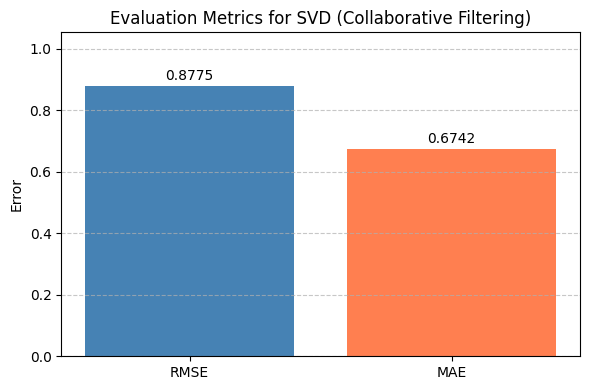

In [23]:
# Visualisasi Evaluasi CF
metrics = ['RMSE', 'MAE']
values = [rmse_val, mae_val]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['steelblue', 'coral'])
plt.title('Evaluation Metrics for SVD (Collaborative Filtering)')
plt.ylabel('Error')
plt.ylim(0, max(values)*1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## **7.2. Evaluasi Content-Based Filtering - Precision@K (DITAMBAHKAN SESUAI FEEDBACK)**

Untuk Content-Based Filtering, yang tujuannya adalah merekomendasikan daftar item (Top-N), kita tidak bisa menggunakan RMSE/MAE. Sebagai gantinya, kita menggunakan metrik berbasis relevansi seperti Precision@K.

- Definisi Precision@K: Mengukur proporsi item yang direkomendasikan dalam K item teratas yang benar-benar relevan bagi pengguna.
- Implementasi di Sini: Karena kita tidak memiliki data relevansi eksplisit, kita membuat simulasi/proxy:
  1. Kita mengambil sample data rating.
  2. Untuk setiap pengguna dalam sample, kita anggap film dengan rating tinggi (>= 4.0) sebagai film yang "relevan".
  3. Kita ambil satu film relevan sebagai input (query) untuk sistem CB kita.
  4. Kita lihat berapa banyak dari K film yang direkomendasikan oleh CB yang juga termasuk dalam daftar film "relevan" pengguna tersebut.
  5. Kita hitung rata-rata presisi ini untuk semua pengguna dalam sample.
- Tujuan: Memberikan gambaran seberapa sering rekomendasi CB "tepat sasaran" berdasarkan rating pengguna.

In [24]:
print("\nEvaluating Content-Based Filtering...")

def calculate_precision_at_k(test_user_items, recommendations, k=5):
    """
    Menghitung Precision@K untuk Content-Based Filtering
    """
    precisions = []

    for user_id, user_items in test_user_items.items():
        if len(user_items) == 0:
            continue

        # Simulasi: ambil film terakhir yang dirating tinggi sebagai query
        highly_rated_items = [item for item, rating in user_items if rating >= 4.0]
        if not highly_rated_items:
            continue

        query_item = highly_rated_items[0]  # Ambil salah satu film yang dirating tinggi

        # Cari judul film query
        query_title = movies[movies['movieId'] == query_item]['title']
        if query_title.empty:
            continue
        query_title = query_title.iloc[0]

        # Dapatkan rekomendasi
        recs = get_enhanced_content_based_recommendations(query_title, N=k)
        if isinstance(recs, str):  # Film tidak ditemukan
            continue

        # Hitung precision
        recommended_items = []
        for _, row in recs.iterrows():
            movie_id = movies[movies['title'] == row['title']]['movieId']
            if not movie_id.empty:
                recommended_items.append(movie_id.iloc[0])

        # Hitung berapa rekomendasi yang relevan (ada di user_items dengan rating tinggi)
        relevant_items = set([item for item, rating in user_items if rating >= 4.0])
        recommended_set = set(recommended_items)

        if len(recommended_set) > 0:
            precision = len(relevant_items.intersection(recommended_set)) / len(recommended_set)
            precisions.append(precision)

    return np.mean(precisions) if precisions else 0.0


Evaluating Content-Based Filtering...


In [25]:

# Persiapkan data test untuk evaluasi Content-Based
test_user_items = defaultdict(list)
for _, row in ratings.sample(1000, random_state=42).iterrows():  # Sample untuk efisiensi
    test_user_items[row['userId']].append((row['movieId'], row['rating']))

precision_at_5 = calculate_precision_at_k(test_user_items, None, k=5)
print(f"Content-Based Filtering Precision@5: {precision_at_5:.4f}")

Content-Based Filtering Precision@5: 0.0243



## **8. CONTOH PENGGUNAAN & HASIL**


Bagian ini menunjukkan bagaimana fungsi rekomendasi yang telah kita buat dapat digunakan untuk menghasilkan rekomendasi nyata untuk pengguna atau berdasarkan film tertentu.


## **8.1. Content-Based Recommendation**

Berikut adalah contoh rekomendasi Content-Based untuk film "Toy Story (1995)". Sistem akan mencari 5 film lain yang memiliki genre dan tag paling mirip.

In [26]:


print("\n--- Generating Examples ---")

display_readable_recommendations("Toy Story (1995)", N=5)



--- Generating Examples ---
----------------------------------------------------------------------
Rekomendasi Content-Based untuk 'Toy Story (1995)':
----------------------------------------------------------------------
 Rank                                          title                                      genres Similarity Score
    1                           Bug's Life, A (1998)         Adventure|Animation|Children|Comedy            0.862
    2                             Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy            0.644
    3               Guardians of the Galaxy 2 (2017)                     Action|Adventure|Sci-Fi            0.368
    4                                    Antz (1998) Adventure|Animation|Children|Comedy|Fantasy            0.358
    5 Adventures of Rocky and Bullwinkle, The (2000) Adventure|Animation|Children|Comedy|Fantasy            0.358
----------------------------------------------------------------------




## **8.2. Collaborative Filtering Recommendation (DITAMBAHKAN SESUAI FEEDBACK)**


Di sini, kita menampilkan rekomendasi Collaborative Filtering Top-5 untuk beberapa pengguna sampel. Rekomendasi ini didasarkan pada prediksi rating tertinggi untuk film-film yang ada di testset (berdasarkan fungsi get_top_n_collaborative_recommendations).

In [27]:
print("Generating Collaborative Filtering recommendations...")
top_n_recommendations = get_top_n_collaborative_recommendations(predictions, n=10)


# Tampilkan rekomendasi untuk beberapa user
sample_users = list(top_n_recommendations.keys())[:3]
for user_id in sample_users:
    display_collaborative_recommendations(user_id, top_n_recommendations, movies, N=5)



Generating Collaborative Filtering recommendations...
----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 140:
----------------------------------------------------------------------
Rank  Movie ID   Predicted Rating Title
----------------------------------------------------------------------
1     48516      4.168           Departed, The (2006)
2     953        4.166           It's a Wonderful Life (1946)
3     2067       4.113           Doctor Zhivago (1965)
4     914        4.094           My Fair Lady (1964)
5     1242       3.975           Glory (1989)
----------------------------------------------------------------------


----------------------------------------------------------------------
Rekomendasi Collaborative Filtering untuk User 603:
----------------------------------------------------------------------
Rank  Movie ID   Predicted Rating Title
----------------------------------------------------------------


## **8.3. Prediksi Rating Spesifik (Collaborative Filtering)**

Selain memberikan daftar rekomendasi, model CF (SVD) juga dapat digunakan untuk memprediksi rating yang mungkin diberikan oleh seorang pengguna untuk film tertentu yang belum ia tonton. Ini berguna untuk memberikan gambaran seberapa besar kemungkinan pengguna akan menyukai film tersebut.

In [28]:

print("--- Prediksi Rating Spesifik ---")
user_id_test = 1
movie_id_toy_story = 1
movie_id_jumanji = 2

title_toy_story = movies[movies['movieId'] == movie_id_toy_story]['title'].iloc[0]
title_jumanji = movies[movies['movieId'] == movie_id_jumanji]['title'].iloc[0]

prediction_toy_story = algo.predict(uid=user_id_test, iid=movie_id_toy_story)
prediction_jumanji = algo.predict(uid=user_id_test, iid=movie_id_jumanji)

print(f"--- Prediksi untuk User {user_id_test} pada '{title_toy_story}' ---")
print(f"Estimasi Rating: {prediction_toy_story.est:.3f}")

print(f"\n--- Prediksi untuk User {user_id_test} pada '{title_jumanji}' ---")
print(f"Estimasi Rating: {prediction_jumanji.est:.3f}")

print("\n=== SUBMISSION COMPLETE ===")

--- Prediksi Rating Spesifik ---
--- Prediksi untuk User 1 pada 'Toy Story (1995)' ---
Estimasi Rating: 4.635

--- Prediksi untuk User 1 pada 'Jumanji (1995)' ---
Estimasi Rating: 4.096

=== SUBMISSION COMPLETE ===
